In [1]:
import subprocess

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 

from od_perturber import od_perturber
from output_reader import output_reader

# Automated OD trials

This is written to be run on a **Linux** machine.

### Automate TSTT calculation for an individual OD matrix perturbation

In [82]:
def tap_trial(
            netFileName,
            demandFileName, 
            perturbType="normal", 
            norm_mean=1, 
            norm_sd=.1, 
            uniform_low=.9, 
            uniform_high=1.1,
            nodesPerturbedAlways=[],
            nodesPerturbedIfOrig=[],
            nodesPerturbedIfDest=[],
            returnDataFrame=False
):
    '''
    Generate a new TSTT calculation for a specific network, trip demands, and perturbation combination.
    '''
    od = od_perturber(
        demandFileName, 
        perturbType, 
        norm_mean, 
        norm_sd, 
        uniform_low, 
        uniform_high,
        nodesPerturbedAlways,
        nodesPerturbedIfOrig,
        nodesPerturbedIfDest
    )
    subprocess.Popen("tap-b/bin/tap " + netFileName + " trips_perturbed.tntp", shell=True).wait()
    if returnDataFrame:
        return output_reader("full_log.txt", netFileName)
    else:
        _,tstt,congestion = output_reader("full_log.txt", netFileName)
        return tstt,congestion

df, true_tstt, true_wvc = tap_trial("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp", norm_mean=1, norm_sd=0, returnDataFrame=True)
true_tstt, true_wvc

(7480171.248174683, 0.019395133470787397)

In [3]:
df.head()

,flow,cost,der,capacity
link,,,,
"(1,2)",4494.611949,6.000816,0.000001,25900.200640
"(1,3)",8119.023795,4.008691,0.000004,23403.473190
"(2,1)",4519.023795,6.000834,0.000001,25900.200640
"(2,6)",5967.349609,6.573612,0.001055,4958.180928
"(3,1)",8094.611949,4.008586,0.000004,23403.473190


### Generate basic trials on Sioux Falls

In [7]:
sds = [0.5, 0.1, 0.01, 0.001, 0]
means = [0.5, 0.9, 0.95, 1.0, 1.05, 1.1, 1.5, 2]
dfres = pd.DataFrame(columns=['mean', 'sd', 'tstt', 'congestion'])
i=0
for mean in means:
    for sd in sds:
        tstt, congestion = tap_trial("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp", norm_mean=mean, norm_sd=sd, returnDataFrame=False)
        dfres.loc[i] = [mean, sd, tstt, congestion]
        i += 1
dfres.to_csv("res.csv")

### Compare results for different means

In [89]:
means = np.arange(0,2,.1)
reses = [tap_trial("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp", norm_mean=mean, norm_sd=0, returnDataFrame=False) for mean in means]
tstts_scaled = np.array([r[0] for r in reses])/true_tstt
congestions = [r[1] for r in reses]

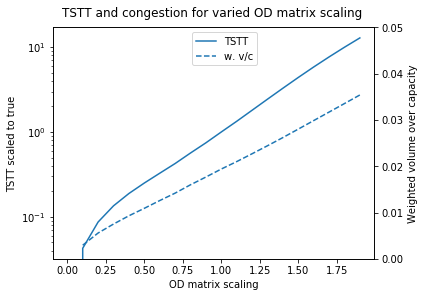

In [90]:
def tstt_wvc_plot(inputs, tstts, congestions, input_name, log_input=False, log_tstt=False, output_fig_name=None):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(input_name)
    ax1.set_ylabel('TSTT scaled to true')
    ax1.plot(inputs, tstts, label='TSTT')
    if log_input:
        ax1.set_xscale('log')
    if log_tstt:
        ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Weighted volume over capacity')
    ax2.plot(inputs, congestions, linestyle='--', label='w. v/c')
    ax2.set_ylim(bottom=0, top=0.05)

    fig.legend(loc=1, bbox_to_anchor=(0.65,1), bbox_transform=ax1.transAxes)
    fig.suptitle('TSTT and congestion for varied {}'.format(input_name), y=1.02)
    fig.tight_layout()
    if output_fig_name:
        plt.savefig(output_fig_name, dpi='figure')
    plt.show()

tstt_wvc_plot(means, tstts_scaled, congestions, 'OD matrix scaling', log_tstt=True)

### Get TSTTs for many trials (with fixed perturbation criteria) at once

In [43]:
def tap_multi_trial(
            netFileName,
            demandFileName, 
            n, 
            perturbType="normal", 
            norm_mean=1, 
            norm_sd=.1, 
            uniform_low=.9, 
            uniform_high=1.1,
            nodesPerturbedAlways=[],
            nodesPerturbedIfOrig=[],
            nodesPerturbedIfDest=[]
):
    return [tap_trial(
        netFileName,
        demandFileName, 
        perturbType, 
        norm_mean, 
        norm_sd, 
        uniform_low, 
        uniform_high,
        nodesPerturbedAlways,
        nodesPerturbedIfOrig,
        nodesPerturbedIfDest,
        returnDataFrame=False
    ) for i in range(n)]

rezzes = tap_multi_trial("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp", 1000)
tstts = pd.Series([r[0] for r in rezzes])
tstts.head()

0    7.474937e+06
1    7.300023e+06
2    7.529735e+06
3    7.438585e+06
4    7.541224e+06
dtype: float64

### Compare results for different standard deviations

In [83]:
sds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
reses_of_reses = [tap_multi_trial("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp", 1000, norm_sd=sd) for sd in sds]
tstts_scaled = np.array([np.mean([r[0] for r in reses]) for reses in reses_of_reses])/true_tstt
congestions = [np.mean([r[1] for r in reses]) for reses in reses_of_reses]

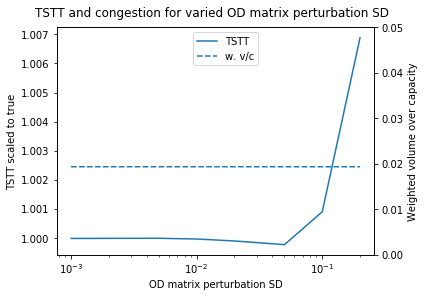

In [87]:
tstt_wvc_plot(sds[:-2], tstts_scaled[:-2], congestions[:-2], 'OD matrix perturbation SD', log_input=True)

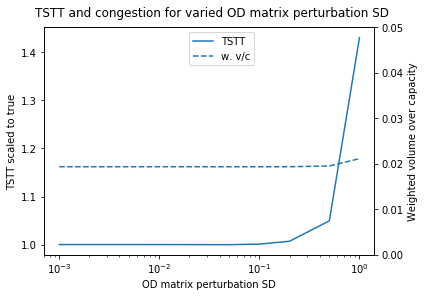

In [88]:
tstt_wvc_plot(sds, tstts_scaled, congestions, 'OD matrix perturbation SD', log_input=True)

### Visualize TSTT from many trials

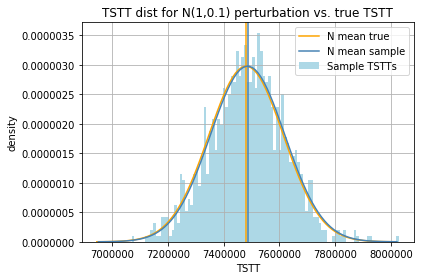

  true mean: 7480155.253
sample mean: 7485610.348461317
sample stdv: 134026.20044016524


In [52]:
def visualize(tstts, mean_true, plot_true_mean=True, img_title=None, img_filename=None, verbose_output=False):
    mean_sample = tstts.mean()
    sd = tstts.std()
    xsnorm = np.linspace(mean_sample - 4*sd, mean_sample + 4*sd, 100)
    xtnorm = np.linspace(mean_true - 4*sd, mean_true + 4*sd, 100)

    tstts.hist(bins=100, label='Sample TSTTs', color='lightblue', density=True)
    if plot_true_mean:
        plt.axvline(x=mean_true, color='orange')
        plt.plot(xtnorm, stats.norm.pdf(xtnorm, mean_true, sd), color='orange', label='N mean true')
    plt.axvline(x=mean_sample, color='steelblue')
    plt.plot(xsnorm, stats.norm.pdf(xsnorm, mean_sample, sd), color='steelblue', label='N mean sample')
    
    if img_title:
        plt.title(img_title)
    plt.ylabel('density')
    plt.xlabel('TSTT')
    plt.legend()
    plt.tight_layout()
    if img_filename:
        plt.savefig(img_filename, dpi='figure')
    plt.show()
    
    if verbose_output:
        print('  true mean:', mean_true)
        print('sample mean:', mean_sample)
        print('sample stdv:', sd)
    
    return mean_sample, sd

mean_true = 7480155.253
n1sdp1_mean, n1sdp1_sd = visualize(tstts, mean_true, img_title='TSTT dist for N(1,0.1) perturbation vs. true TSTT', img_filename='normcompare.png', verbose_output=True)

## Monte Carlo simulations

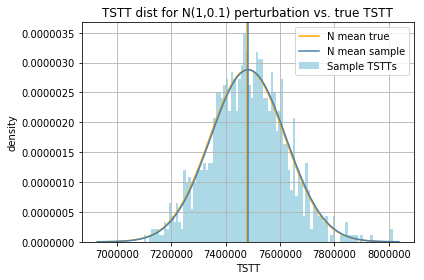

  true mean: 7480155.253
sample mean: 7483612.255335508
sample stdv: 138378.59647296442


In [92]:
def monte_carlo(
    mean_true,    
    
    netFileName,
    demandFileName, 
    n, 
    perturbType="normal", 
    norm_mean=1, 
    norm_sd=.1, 
    uniform_low=.9, 
    uniform_high=1.1,
    nodesPerturbedAlways=[],
    nodesPerturbedIfOrig=[],
    nodesPerturbedIfDest=[],
    
    trials_csv=None,
    
    plot_true_mean=True,
    img_title=None, 
    img_filename=None, 
    verbose_output=False
):
    rezzes = tap_multi_trial(
        netFileName,
        demandFileName, 
        n,
        perturbType, 
        norm_mean, 
        norm_sd, 
        uniform_low, 
        uniform_high,
        nodesPerturbedAlways,
        nodesPerturbedIfOrig,
        nodesPerturbedIfDest
    )
    tstts = pd.Series([r[0] for r in rezzes])
    if trials_csv:
        pd.DataFrame({
            'mean': np.ones(n)*norm_mean,
            'sd': np.ones(n)*norm_sd,
            'TSTT': tstts
        } if perturbType is 'normal' else {
            'low': np.ones(n)*uniform_low,
            'high': np.ones(n)*uniform_high,
            'TSTT': tstts
        }).to_csv(trials_csv)
    return visualize(tstts, mean_true, plot_true_mean, img_title=img_title, img_filename=img_filename, verbose_output=verbose_output)

n1sdp1_mean, n1sdp1_sd = monte_carlo(mean_true, 
                                     "SiouxFalls_net.tntp", 
                                     "SiouxFalls_trips.tntp", 
                                     1000, 
                                     trials_csv='n(1,p1).csv', 
                                     img_title='TSTT dist for N(1,0.1) perturbation vs. true TSTT', 
                                     img_filename='n(1,p1).png', 
                                     verbose_output=True)

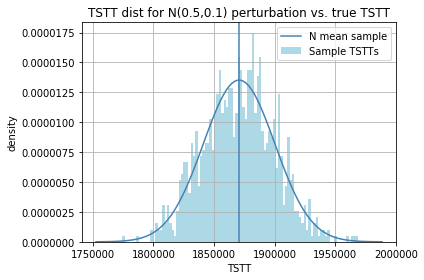

  true mean: 7480155.253
sample mean: 1870777.075757287
sample stdv: 29495.780865486373


In [112]:
np5sdp1_mean, np5sdp1_sd = monte_carlo(mean_true, 
                                       "SiouxFalls_net.tntp", 
                                       "SiouxFalls_trips.tntp", 
                                       1000, 
                                       norm_mean=.5,
                                       trials_csv='n(p5,p1).csv', 
                                       plot_true_mean=False,
                                       img_title='TSTT dist for N(0.5,0.1) perturbation vs. true TSTT', 
                                       img_filename='n(p5,p1).png', 
                                       verbose_output=True)

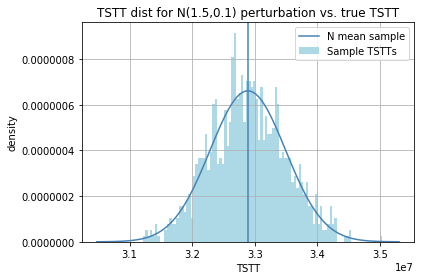

  true mean: 7480155.253
sample mean: 32888137.60132828
sample stdv: 603552.8894860788


In [111]:
n1p5sdp1_mean, n1p5sdp1_sd = monte_carlo(mean_true,
                                         "SiouxFalls_net.tntp", 
                                         "SiouxFalls_trips.tntp", 
                                         1000, 
                                         norm_mean=1.5,
                                         trials_csv='n(1p5,p1).csv',
                                         plot_true_mean=False,
                                         img_title='TSTT dist for N(1.5,0.1) perturbation vs. true TSTT', 
                                         img_filename='n(1p5,p1).png', 
                                         verbose_output=True)

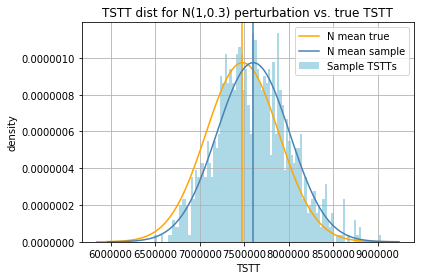

  true mean: 7480155.253
sample mean: 7601659.454478956
sample stdv: 409255.67778822157


In [93]:
n1sdp3_mean, n1sdp3_sd = monte_carlo(mean_true,
                                         "SiouxFalls_net.tntp", 
                                         "SiouxFalls_trips.tntp", 
                                         1000, 
                                         norm_sd=0.3,
                                         trials_csv='n(1,p3).csv',
                                         img_title='TSTT dist for N(1,0.3) perturbation vs. true TSTT', 
                                         img_filename='n(1,p3).png', 
                                         verbose_output=True)